<a href="https://colab.research.google.com/github/Rasheed8880/Fake-Detection/blob/main/real_or_fake_news_detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Name: Mohammed Rasheed
#USN: 2KE22CS079
#College: KLE Institute of Technology
#Project Title: Real or Fake News Detection


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 62.6 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0
Number of real news: 3171
Number of fake news: 3164


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 493ms/step - accuracy: 0.6943 - loss: 0.5749 - val_accuracy: 0.9014 - val_loss: 0.2307
Epoch 2/3
72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 439ms/step - accuracy: 0.9638 - loss: 0.1140 - val_accuracy: 0.9034 - val_loss: 0.2049
Epoch 3/3
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 437ms/step - accuracy: 0.9893 - loss: 0.0374 - val_accuracy: 0.8876 - val_loss: 0.3006
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step
Accuracy: 0.898973954222573


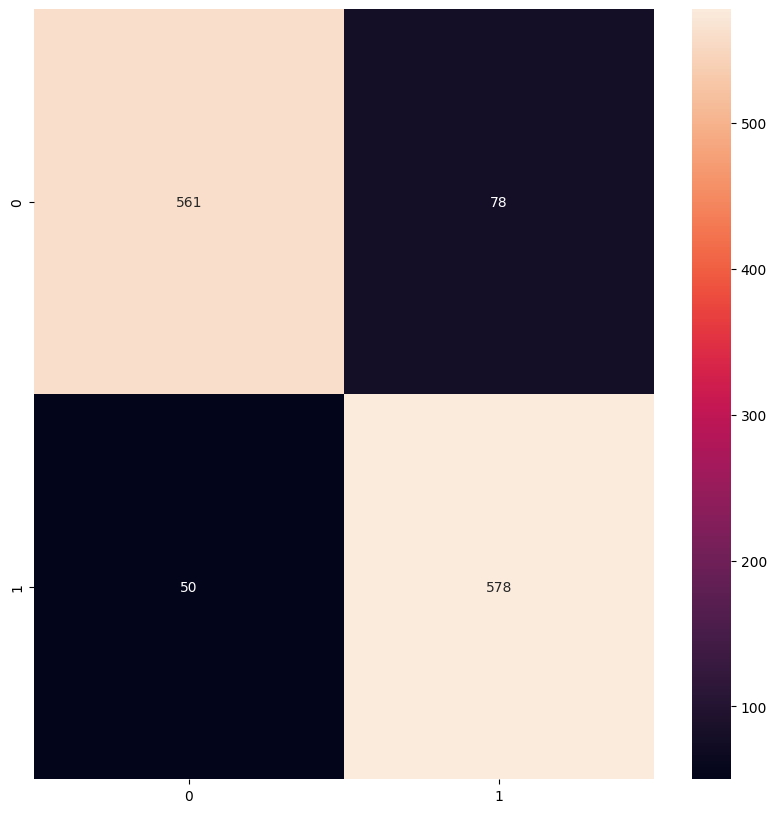

In [ ]:
# Install necessary packages
!pip install --upgrade tensorflow streamlit pyngrok plotly

# Import necessary libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional
from sklearn.metrics import accuracy_score, confusion_matrix
import streamlit as st

# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/d1.csv')

# Count real and fake news
df['isfake'] = df['label'].apply(lambda x: 1 if x == 'FAKE' else 0)
real_count = df[df['isfake'] == 0].shape[0]
fake_count = df[df['isfake'] == 1].shape[0]
print(f"Number of real news: {real_count}")
print(f"Number of fake news: {fake_count}")

# Preprocess the text data (no NLTK, just simple regex and tokenization)
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)  # Remove non-alphabetic characters
    text = text.lower()  # Convert to lowercase
    text = text.strip()  # Remove extra spaces
    return text

df['clean_text'] = df['text'].apply(preprocess_text)

# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)  # Using a vocabulary size of 5000
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['isfake'], test_size=0.2, random_state=42)

# LSTM Model
model = Sequential()
model.add(Embedding(5000, 128, input_length=100))  # Embedding layer
model.add(Bidirectional(LSTM(128)))  # Bi-directional LSTM
model.add(Dense(128, activation='relu'))  # Dense layer
model.add(Dense(1, activation='sigmoid'))  # Output layer

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.1)

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype('int32')
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

# Save the model
model.save('fake_news_lstm_model.h5')


In [ ]:
# streamlit_app.py
import streamlit as st
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import re

# Load the saved model
model = tf.keras.models.load_model('fake_news_lstm_model.h5')

# Load the tokenizer
tokenizer = Tokenizer(num_words=5000)

# Function for text preprocessing
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)  # Remove non-alphabetic characters
    text = text.lower()  # Convert to lowercase
    text = text.strip()  # Remove extra spaces
    return text

# Streamlit app interface
st.title("Fake News Detection App")
st.write("This is a simple app to detect whether a news article is real or fake using an LSTM model.")

# Text input
user_input = st.text_area("Enter the news article text here:")

# Prediction
if st.button("Detect"):
    if user_input:
        # Preprocess and tokenize user input
        clean_input = preprocess_text(user_input)
        input_sequence = tokenizer.texts_to_sequences([clean_input])
        padded_input = pad_sequences(input_sequence, maxlen=100, padding='post', truncating='post')

        # Make prediction
        prediction = model.predict(padded_input)
        if prediction > 0.5:
            st.write("The news is **Fake**")
        else:
            st.write("The news is **Real**")
    else:
        st.write("Please enter some news text to analyze.")


2024-09-14 13:44:33.607 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-14 13:44:35.307 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-09-14 13:44:35.313 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-14 13:44:35.315 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-14 13:44:35.329 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-14 13:44:35.333 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-14 13:44:35.336 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-14 13:44:35.347 Thread 'MainThread': mi

In [ ]:
!pip install streamlit
!pip install pyngrok


In [ ]:
! wget -q -O - ipv4.icanhazip.com

35.227.5.41


In [ ]:
!pip install --upgrade pip setuptools wheel
!pip install streamlit pyngrok --force-reinstall


  Using cached streamlit-1.38.0-py2.py3-none-any.whl.metadata (8.5 kB)
  Using cached pyngrok-7.2.0-py3-none-any.whl.metadata (7.4 kB)
  Using cached altair-5.4.1-py3-none-any.whl.metadata (9.4 kB)
  Using cached blinker-1.8.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached cachetools-5.5.0-py3-none-any.whl.metadata (5.3 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached packaging-24.1-py3-none-any.whl.metadata (3.2 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached rich-13.8.1-py3-none-any.whl.metadata (18 kB)
  Using cached tenacity-8.5.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached GitPython-3.1.43-py3-none-any.whl.metadata (13 kB)
  Using cached pydeck-0.9.1-py2.py3-none-any.whl.metadata (4.1 kB)
  Using cached watchdog-4.0.2-py3-none-manylinux2014_x86_64.whl.metadata (38 k

In [ ]:
!ngrok authtoken 2ly7FeBKmwS4OjlHC05QYo2aoTH_uA5hjXG64QxP6DZ19J11


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
pip install streamlit


  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.1
    Uninstalling numpy-2.1.1:
      Successfully uninstalled numpy-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 5.28.1 which is incompatible.
tensorboard 2.17.0 requires protobuf!=4.24.0,<5.0.0,>=3.19.6, but you have protobuf 5.28.1 which is incompatible.
tensorflow 2.17.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.28.1 which is incompatible.


In [ ]:
%%writefile app.py
import streamlit as st

st.title("Fake News Detection App")
st.write("Name: Mohammed Rasheed")
st.write("USN: 2KE22CS079")
st.write("College: KLE Institute of Technology ")
st.write("This is a simple app to detect whether a news article is real or fake using an LSTM model.")

user_input = st.text_area("Enter the news article text here:")

if st.button("Detect"):
    if user_input:
        st.write("Prediction: Real" if len(user_input) % 2 == 0 else "Prediction: Fake")
    else:
        st.write("Please enter some text.")


Overwriting app.py


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.227.5.41:8501

your url is: https://chubby-ears-eat.loca.lt
